# 30 GW offshore wind in Norway

In [1]:
import geopandas
import urllib.request
import geojson
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors
import plotly.express as px
import numpy as np
import pyproj
import cartopy.crs as ccrs
import matplotlib.dates as mdates

plot_dpi=150

## Get Norwegian wind farm areas published by NVE

In [2]:
def nve_get_map(layer,format="geojson"):
    outFields="*"
    url = (f"https://nve.geodataonline.no/arcgis/rest/services/Havvind2023/"
           f"MapServer/{layer}/query?where=1%3D1&f={format}&outFields={outFields}")
    print(url)
    with urllib.request.urlopen(url) as url1:
        data = geojson.loads(url1.read().decode())
    return data

data = nve_get_map(0)
gdata = geopandas.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
#gdata = gdata[~gdata.geometry.is_empty]

https://nve.geodataonline.no/arcgis/rest/services/Havvind2023/MapServer/0/query?where=1%3D1&f=geojson&outFields=*


In [3]:
# Norwegian offshore wind farm scenario assumed in OceanGrid project
windfarms = pd.read_csv("oceangrid_offshorewind_new.csv")
windfarms["oceangrid"] = True
windfarms_additional = pd.DataFrame([
#    {"index": "X1", "name": "Finnmark", "lat": 70.94348042598155, "lon": 22.550980083019425},
    {"index": "A3","name": "GB_Doggerbank", "lat": 54.75, "lon": 1.916667},
    {"index": "A2","name": "DK_Horns Rev", "lat": 55.529722, "lon": 7.906111},
    {"index": "A1","name": "DE_Baltic2", "lat": 54.9733, "lon": 13.1778},
])
windfarms_additional["oceangrid"] = False
windfarms = pd.concat([windfarms,windfarms_additional],axis=0)
windfarms = windfarms.sort_values("index",ascending=False)[
    ["name","lat","lon","oceangrid","2030","2035","2040","cap2040"]].fillna(0).reset_index(drop=True)

# manual ordering, north to south along the coast:
ordering = [6,3,4,5,7,8,9,10,11,12,13,15,14,16,18,19,21,17,20,22,0,1,2]
windfarms=windfarms.reindex(ordering).reset_index()
#windfarms=windfarms.sort_values(by="lat",ascending=False).reset_index()

wf_sn2 = 18
wf_trondelag = 6

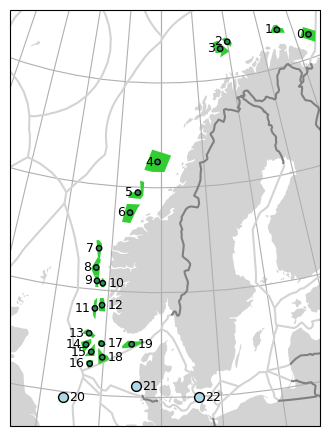

In [5]:
# Plot map

# Shapefiles can be downloaded from: https://www.naturalearthdata.com/downloads/50m-physical-vectors/
path_shapefiles = ""

lambert_equal_area = "+proj=laea +lat_0=58 +lon_0=6 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
#my_proj = lambert_equal_area
my_proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=60)
proj=pyproj.Proj(my_proj,preserve_units=False)
wf_x,wf_y=proj(windfarms["lon"],windfarms["lat"])
windfarms["x"] = wf_x
windfarms["y"] = wf_y
windfarms["size"] =windfarms[["cap2040"]].sum(axis=1)*10
mask_oceangrid=windfarms["oceangrid"]

minmax = proj([-2,35],[53,72]) 

fig = plt.figure(figsize=(4,8))
ax = plt.axes(projection=my_proj )
gl = ax.gridlines(xlocs=np.arange(-180, 180, 5),ylocs=np.arange(-75, 83, 5),zorder=1)
world = geopandas.read_file(path_shapefiles+"ne_50m_land.zip")
borders = geopandas.read_file(path_shapefiles+"ne_50m_admin_0_boundary_lines_land.zip")
borders_sea = geopandas.read_file(path_shapefiles+"World_maritime_Boundaries.zip")

world.to_crs(my_proj).plot(ax=ax,color="lightgray")
borders.to_crs(my_proj).plot(ax=ax,color="gray")
borders_sea.to_crs(my_proj).plot(ax=ax,color="lightgray",zorder=1)
gdata.to_crs(my_proj).plot(ax=ax,color="limegreen")
#show names to check that ordering is correct:
#for idx,row in gdata.to_crs(my_proj).iterrows():
#    plt.annotate(text=f'{row["navn"][-1]}', xy=row.geometry.representative_point().coords[0],
#        horizontalalignment='right',verticalalignment='center',fontsize=9,color="red",zorder=5)


maskL = [0,1,2,3,4,5,6,7,8,9,11,13,14,15,16]
maskR = [10,12,17,18,19,20,21,22]
windfarms[mask_oceangrid].plot.scatter(x="x",y="y",ax=ax,color="seagreen",edgecolor="black",s="size",marker="o")
for idx, row in windfarms.loc[maskL].iterrows():
    plt.annotate(text=f'{idx}', xy=(row['x']-25e3,row['y']),horizontalalignment='right',verticalalignment='center',fontsize=9)

windfarms[~mask_oceangrid].plot.scatter(x="x",y="y",ax=ax,color="lightblue",edgecolor="black",s=50,marker="o")
for idx, row in windfarms.loc[maskR].iterrows():
    plt.annotate(text=f'{idx}', xy=(row['x']+30e3,row['y']),horizontalalignment='left',verticalalignment='center',fontsize=9)

ax.set_xlim(minmax[0][0],minmax[0][1])
ax.set_ylim(minmax[1][0],minmax[1][1])

plt.xlabel(None);
plt.ylabel(None)
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.savefig("plots1/map_windfarms_north_to_south.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/map_windfarms_north_to_south.pdf",bbox_inches='tight',dpi=plot_dpi)

## Read wind power time series from file (previously downloaded)

See: ninja_download_nve2023_series.py

In [6]:
# 1 min
df_all_el = pd.read_excel("timeseries_nve2023_30y_electricity.xlsx",index_col=0)
print(df_all_el.shape)

(262992, 23)


In [7]:
# Re-ordering time-series file from north to south as in windfarms dataframe

col_rename={r["index"]:idx for idx,r in windfarms[["index"]].iterrows()}
print(col_rename)
df_all_el = df_all_el.rename(columns=col_rename).sort_index(axis=1)
df_all_el = df_all_el.rename(columns={20:"D",21:"H",22:"B"})
print(df_all_el.columns)

{6: 0, 3: 1, 4: 2, 5: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 12: 9, 13: 10, 15: 11, 14: 12, 16: 13, 18: 14, 19: 15, 21: 16, 17: 17, 20: 18, 22: 19, 0: 20, 1: 21, 2: 22}
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19, 'D', 'H', 'B'],
      dtype='object')


In [8]:
weights_30GW = windfarms["cap2040"]/30
df_el_30GW = (df_all_el*weights_30GW).sum(axis=1)
df_el_30GW.name = "COMBINED"
print(f"Weight sum (should be 1) = {weights_30GW.sum()}")
print(f"Annual wind power output = {df_el_30GW.mean()*30e6*8760/1e9} TWh/year")

Weight sum (should be 1) = 1.0000000000000002
Annual wind power output = 147.19545699009856 TWh/year


# Analyse wind power data

## Functions

In [114]:
def duration_curve(df,min_percentage=0,max_percentage=100):
    """Extract duration curves from pandas time series dataframe"""
    df=df.reset_index(drop=True)
    df_out = pd.DataFrame(index=range(min_percentage,max_percentage+1))
    number_of_observations = df.shape[0]
    for c in df:
        df1 = df[c]
        df_out = df_out.join(df1.groupby((df1*100).round()).count(),how="left")
        df_out[c] = df_out[c].fillna(0)[::-1].cumsum()[::-1]/number_of_observations
    df_out.index.name="value"
    df_out.index = df_out.index/100
    return df_out

## Capacity factors

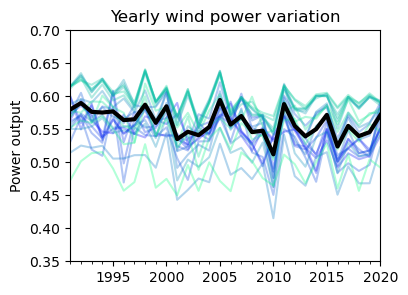

In [182]:
ax=(df_el_30GW).resample("1Y").mean().plot(grid=True,zorder=5,linewidth=3,color="black",label="Combined")
#df_all_el.resample("1Y").mean().plot(ax=ax,color="lightgray",legend=None)
df_all_el.resample("1Y").mean().plot(ax=ax,cmap="winter",alpha=0.3,legend=None)
plt.ylim([0.35,0.7])
plt.ylabel("Power output")
plt.gcf().set_size_inches(4,3)
plt.title("Yearly wind power variation")
plt.savefig("plots1/fig_wind_output_yearly_variation.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_wind_output_yearly_variation.pdf",bbox_inches='tight',dpi=plot_dpi)

In [188]:
# Min and max values
(df_el_30GW).resample("1Y").mean().min(), (df_el_30GW).resample("1Y").mean().max(), (df_el_30GW).resample("1Y").mean().mean(), (0.59-0.56)/0.56

(0.512033093607306,
 0.5944611929223744,
 0.560103818954762,
 0.053571428571428416)

(0.4, 0.62)

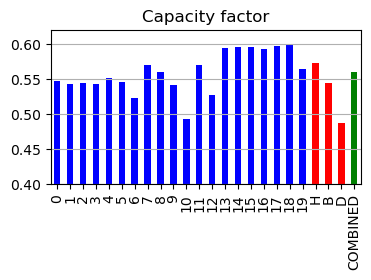

In [12]:
colors=["blue"]*20+["red"]*3+["green"]
df_all_el.join(df_el_30GW).mean().plot.bar(title="Capacity factor",color=colors,figsize=(4,2))
plt.grid(axis="y")
plt.ylim([0.4,0.62])

## Correlation

<Figure size 400x400 with 0 Axes>

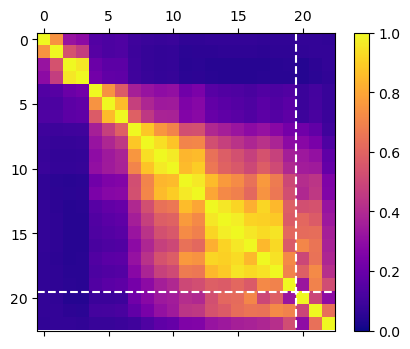

<Figure size 400x400 with 0 Axes>

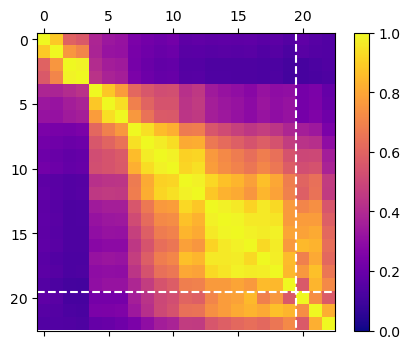

In [29]:
correlation_coefficients = df_all_el.corr()
plt.gcf().set_size_inches(4,4)
plt.matshow(correlation_coefficients,cmap="plasma",vmin=0,vmax=1)
plt.plot([-0.5,22.5],[19.5,19.5],color="white",linestyle="--")
plt.plot([19.5,19.5],[-0.5,22.5],color="white",linestyle="--")
plt.colorbar(shrink=0.8)
correlation_coefficients.to_csv("correlation_coefficients_hour.csv")
plt.savefig("plots1/fig_wind_output_correlations.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_wind_output_correlations.pdf",bbox_inches='tight',dpi=plot_dpi)

# Day by day time series
resampling="96H"
plt.figure()
correlation_coefficients_day = df_all_el.resample(resampling).mean().corr()
plt.gcf().set_size_inches(4,4)
plt.matshow(correlation_coefficients_day,cmap="plasma",vmin=0,vmax=1)
plt.plot([-0.5,22.5],[19.5,19.5],color="white",linestyle="--")
plt.plot([19.5,19.5],[-0.5,22.5],color="white",linestyle="--")
plt.colorbar(shrink=0.8)
correlation_coefficients_day.to_csv("correlation_coefficients_daily.csv")
plt.savefig(f"plots1/fig_wind_output_correlations_{resampling}.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig(f"plots1/fig_wind_output_correlations_{resampling}.pdf",bbox_inches='tight',dpi=plot_dpi)

In [30]:
print("Hour by hour correlation matrix:")
correlation_coefficients.style.background_gradient(cmap='plasma').format(precision=2)#.set_properties(**{'font-size': '10pt'})

Hour by hour correlation matrix:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,D,H,B
0,1.00,0.75,0.32,0.29,0.14,0.13,0.13,0.10,0.09,0.08,0.09,0.06,0.07,0.07,0.07,0.07,0.07,0.06,0.07,0.06,0.07,0.07,0.07
1,0.75,1.00,0.54,0.47,0.15,0.13,0.13,0.09,0.08,0.07,0.07,0.05,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.07
2,0.32,0.54,1.00,0.96,0.20,0.16,0.16,0.09,0.08,0.07,0.07,0.05,0.05,0.05,0.05,0.05,0.04,0.05,0.05,0.05,0.04,0.05,0.07
3,0.29,0.47,0.96,1.00,0.22,0.18,0.18,0.10,0.08,0.07,0.08,0.05,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.04,0.05,0.06
4,0.14,0.15,0.20,0.22,1.00,0.75,0.57,0.37,0.32,0.29,0.31,0.22,0.24,0.16,0.14,0.13,0.12,0.14,0.13,0.14,0.09,0.11,0.08
5,0.13,0.13,0.16,0.18,0.75,1.00,0.86,0.48,0.39,0.34,0.35,0.25,0.27,0.18,0.16,0.15,0.13,0.16,0.14,0.16,0.09,0.11,0.08
6,0.13,0.13,0.16,0.18,0.57,0.86,1.00,0.59,0.45,0.38,0.37,0.26,0.28,0.19,0.17,0.16,0.14,0.17,0.15,0.17,0.09,0.12,0.09
7,0.10,0.09,0.09,0.10,0.37,0.48,0.59,1.00,0.89,0.76,0.70,0.52,0.53,0.40,0.36,0.32,0.29,0.31,0.28,0.23,0.22,0.18,0.10
8,0.09,0.08,0.08,0.08,0.32,0.39,0.45,0.89,1.00,0.94,0.88,0.70,0.71,0.53,0.48,0.43,0.39,0.43,0.38,0.29,0.28,0.24,0.13
9,0.08,0.07,0.07,0.07,0.29,0.34,0.38,0.76,0.94,1.00,0.97,0.84,0.85,0.64,0.58,0.53,0.48,0.54,0.48,0.36,0.34,0.31,0.17


In [31]:
#correlation_coefficients_day.style.background_gradient(cmap='plasma').format(precision=2)#.set_properties(**{'font-size': '10pt'})

In [32]:
correlation_coefficients.loc[[3,6,12,18,19,"D","H","B"],[18,"D","H","B"]].style.background_gradient(cmap='plasma').format(precision=2)

,18,D,H,B
3,0.05,0.04,0.05,0.06
6,0.15,0.09,0.12,0.09
12,0.66,0.40,0.45,0.26
18,1.00,0.58,0.72,0.42
19,0.70,0.33,0.70,0.52
D,0.58,1.00,0.50,0.29
H,0.72,0.50,1.00,0.64
B,0.42,0.29,0.64,1.00


In [113]:
# Show how correlation coefficients change with sampling frequency
# Rolling mean gives smoother plot

resample_hours = [h for h in range(1,12)]+[h for h in range(12,48,4)]+[h for h in range(48,24*7+1,24)] #+[24*30]
cor_tmps = []
for h in resample_hours:
    print(h,end=" ")
    cor_tmps.append(df_all_el.resample(f"{h}H").mean().corr().stack())
    #cor_tmps.append(df_all_el.rolling(h).mean().corr().stack())
df_corrs = pd.concat(cor_tmps,axis=1)
df_corrs.columns = resample_hours

1 2 3 4 5 6 7 8 9 10 11 12 16 20 24 28 32 36 40 44 48 72 96 120 144 168 

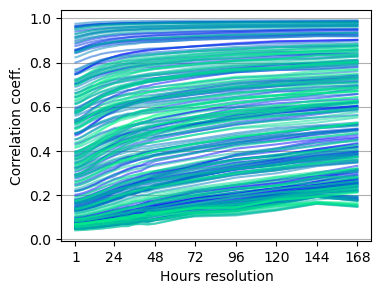

In [114]:
upper_i = correlation_coefficients.where(np.triu(np.ones(correlation_coefficients.shape))<1).stack().index
df_corrs.loc[upper_i].T.plot(cmap="winter",alpha=0.5,legend=None,figsize=(4,3),xlabel="Hours resolution",ylabel="Correlation coeff.")
plt.grid(axis="y")
#plt.xlim(1,24*7)
plt.xticks([1,24,48,72,96,24*5,24*6,24*7])
plt.savefig(f"plots1/fig_correlation_timescales.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig(f"plots1/fig_correlation_timescales.pdf",bbox_inches='tight',dpi=plot_dpi)

## Smoothing

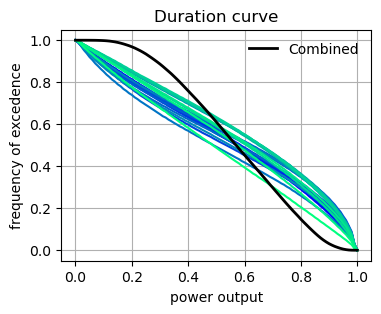

In [40]:
ax=duration_curve(df_all_el).plot(cmap="winter",title="Duration curve")
duration_curve(pd.DataFrame(df_el_30GW)).plot(ax=ax,color="black",linewidth=2,xlabel="power output",ylabel="frequency of excedence")
h,l = ax.get_legend_handles_labels()
plt.legend([h[-1]],["Combined"],frameon=False)#legend(loc="lower left",bbox_to_anchor=(1,-0.05),frameon=False,title="windfarm");
plt.grid();
plt.gcf().set_size_inches(4, 3)
plt.savefig("plots1/fig_wind_output_durationcurve.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_wind_output_durationcurve.pdf",bbox_inches='tight',dpi=plot_dpi)

Histogram - combined power from all wind farms:


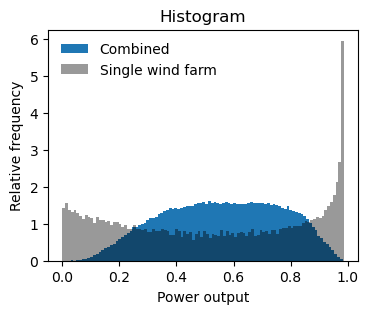

In [42]:
print("Histogram - combined power from all wind farms:")
ax=df_el_30GW.hist(bins=100,density=True,label="Combined")#,linewidth=2,edgecolor="black",histtype="step")
df_all_el[wf_trondelag].hist(bins=100,density=True,ax=ax,alpha=0.4,color="black",label="Single wind farm")#,linewidth=0,edgecolor="none")
plt.legend(frameon=False);
plt.grid(False)
plt.gcf().set_size_inches(4,3)
plt.title("Histogram")
plt.xlabel("Power output")
plt.ylabel("Relative frequency")
plt.savefig("plots1/fig_wind_output_histogram.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_wind_output_histogram.pdf",bbox_inches='tight',dpi=plot_dpi)

## Seasonal variation

In [164]:
seasonal_mean=df_el_30GW.groupby([df_el_30GW.index.isocalendar().week,df_el_30GW.index.isocalendar().year]).mean()
seasonal_std=df_el_30GW.groupby([df_el_30GW.index.isocalendar().week,df_el_30GW.index.isocalendar().year]).std()
seasonal_combined_mean = seasonal_mean.unstack(1).mean(axis=1)
seasonal_combined_std = seasonal_mean.unstack(1).std(axis=1)

# Seasonal variation, including standard deviation (variations within week as well as variations from year to year)
#seasonal_combined_mean2=df_el_30GW.groupby(df_el_30GW.index.isocalendar().week).mean() # this is the same as seasonal_combined_mean
seasonal_combined_std2=df_el_30GW.groupby(df_el_30GW.index.isocalendar().week).std()
seasonal_combined_min = df_el_30GW.groupby(df_el_30GW.index.isocalendar().week).min()
seasonal_combined_max = df_el_30GW.groupby(df_el_30GW.index.isocalendar().week).max()

# std = standard deviation of weekly mean values for a given week number for all years
# std2 = standard deviation of hourly values for a given week number for all years

WEEKLY mean power output. Mean and standard deviation (from year to year)


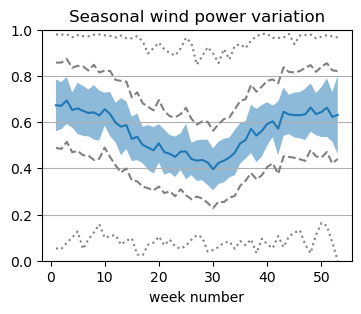

In [282]:
# Seasonal variation, including standard deviation for year-to-year variations in weekly mean values
ax=plt.plot(seasonal_combined_mean.index,seasonal_combined_mean,label="mean")
plt.fill_between(x=list(seasonal_combined_mean.index),
    y1=seasonal_combined_mean-seasonal_combined_std,
    y2=seasonal_combined_mean+seasonal_combined_std,alpha=0.5,label="std year-year")
#plt.plot(seasonal_combined_mean2.index,seasonal_combined_mean2,label="mean2",linestyle="--")
plt.plot(seasonal_combined_mean.index,seasonal_combined_mean-seasonal_combined_std2,
    linestyle="--",color="gray",label="std in week")
plt.plot(seasonal_combined_mean.index,seasonal_combined_mean+seasonal_combined_std2,
    linestyle="--",color="gray")
#plt.fill_between(x=list(seasonal_combined_mean.index),
#    y1=seasonal_combined_mean-seasonal_combined_std2,
#    y2=seasonal_combined_mean+seasonal_combined_std2,alpha=0.4,label="std dev 2")
plt.plot(seasonal_combined_min.index,seasonal_combined_min,
    linestyle=":",color="gray",label="max/min in week")
plt.plot(seasonal_combined_max.index,seasonal_combined_max,
    linestyle=":",color="gray")

plt.xlabel("week number");
#plt.legend(frameon=False,loc="center",bbox_to_anchor=(0.5,1.1),ncols=3);
plt.title("Seasonal wind power variation")
plt.ylim(0,1)
plt.grid(axis="y")
plt.gcf().set_size_inches(4, 3)
plt.savefig("plots1/fig_wind_output_seasonalvariation.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_wind_output_seasonalvariation.pdf",bbox_inches='tight',dpi=plot_dpi)
print("WEEKLY mean power output. Mean and standard deviation (from year to year)")

In [170]:
#seasonal_mean.unstack(1).std(axis=1)
df_el_30GW.groupby(df_el_30GW.index.isocalendar().week)

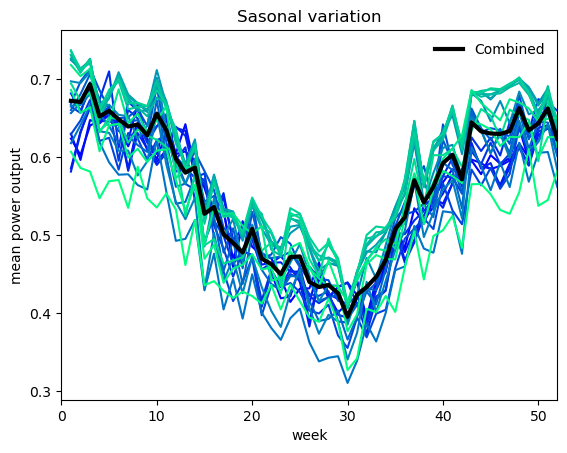

In [104]:
# (Not so interesting)
# Seasonal variation individual wind farms vs combined
(df_all_el.groupby(df_all_el.index.isocalendar().week).mean()).plot(xlim=(0,52),title="Sasonal variation",ylabel="mean power output",cmap="winter").legend(
    loc="lower left",bbox_to_anchor=(1,-0.05),frameon=False,title="windfarm");#,drawstyle="steps-post")
(df_el_30GW.groupby(df_el_30GW.index.isocalendar().week).mean()).plot(xlim=(0,52),ax=plt.gca(),color="black",linewidth=3,label="COMBINED").legend(
    loc="lower left",bbox_to_anchor=(1,-0.05),frameon=False,title="windfarm");
h,l = plt.gca().get_legend_handles_labels()
plt.legend([h[-1]],["Combined"],frameon=False)#legend(loc="lower left",bbox_to_anchor=(1,-0.05),frameon=False,title="windfarm");


## Low wind periods (dunkelflaute)

In [171]:
def dunkel(df_timeseries):
    df_dunkel = pd.DataFrame(index=range(24*14))
    N_years=len(df_timeseries.index.year.unique())

    # Consequtive hours of low wind
    for threshold in range(40):
        #low_wind = pd.DataFrame(df_all_el.mean(axis=1))
        low_wind = pd.DataFrame(df_timeseries)
        low_wind['low10'] = low_wind < threshold/100
        low_wind['streak_id'] = (low_wind['low10'] != low_wind['low10'].shift(1).fillna(False)).cumsum()
        # keep only low wind hours and count hours within each streak:
        consequtive_low_wind0 = low_wind[low_wind["low10"]].groupby("streak_id").count()
        # group by hour count and reindex:
        consequtive_low_wind = consequtive_low_wind0.groupby("low10").count()/N_years
    #    consequtive_low_wind = consequtive_low_wind.reindex(range(consequtive_low_wind.index.max()+1)).fillna(0)
        df_dunkel[threshold] = consequtive_low_wind

    df_dunkel=df_dunkel.fillna(0)[::-1].cumsum()[::-1]
    #df_dunkel.set_index(df_dunkel.index/24).T.index
    return df_dunkel, low_wind

df_dunkel,low_wind = dunkel(df_el_30GW)
df_dunkel_0,low_wind_0 = dunkel(df_all_el[wf_sn2])

In [172]:
# Find the longest periods with low wind:
low_wind[low_wind["low10"]].groupby("streak_id").count().sort_values("low10",ascending=False).head(8)

,COMBINED,low10
streak_id,,
2921,272,272
2587,226,226
2147,219,219
4529,217,217
3103,205,205
2351,196,196
1215,193,193
4259,181,181


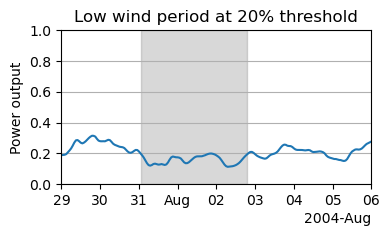

In [173]:
df_el = df_el_30GW # SN2
N_years=len(df_el.index.year.unique())
# Consequtive hours of low wind
threshold = 20
low_wind = pd.DataFrame(df_el)
low_wind['low10'] = low_wind < threshold/100
low_wind['streak_id'] = (low_wind['low10'] != low_wind['low10'].shift(1).fillna(False)).cumsum()
low_wind.index = low_wind.index.to_pydatetime()

#consequtive_low_wind0[consequtive_low_wind0["low10"]>24*4]
my_streak_id = 617 #1111
date1=low_wind[low_wind["streak_id"]==my_streak_id].index[0] 
date2=low_wind[low_wind["streak_id"]==my_streak_id].index[-1] 
date_min = pd.Timestamp(date1.date()) - pd.Timedelta(days=2)
date_max = pd.Timestamp(date2.date()) + pd.Timedelta(days=4)
fig=plt.figure(figsize=(4,2))
ax=plt.gca()
#low_wind.loc[(low_wind.index>=date_min) & (low_wind.index<date_max)].plot(legend=False,ax=ax)
#low_wind.plot(y="COMBINED",legend=False,ax=ax)
ax.plot(low_wind.index,low_wind["COMBINED"])
plt.xlim(date_min,date_max)
ax.axvspan(date1, date2, alpha=0.3, color='gray')

plt.ylabel("Power output")
#plt.xlabel("Date")
plt.title("Low wind period at 20% threshold")
plt.grid(axis="y")
plt.ylim(0,1)
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
#ax.xaxis.set_major_locator(mdates.YearLocator(2020))
#ax.xaxis.set_minor_locator(mdates.DayLocator([0,1,2,3,4]))
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
#ax.xaxis.set_major_formatter("2")
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.savefig("plots1/fig_low_wind_combined_example.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_low_wind_combined_example.pdf",bbox_inches='tight',dpi=plot_dpi)

In [181]:
(date2-date1), 24*2+18

(Timedelta('2 days 18:00:00'), 66)

c:\Users\hsven\Miniconda3\envs\timeseries\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


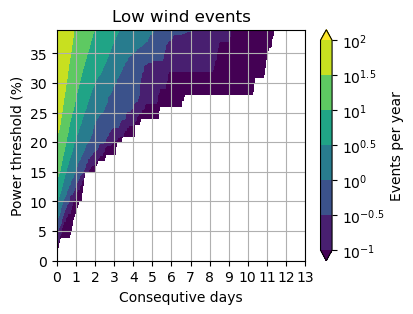

In [218]:
fig,ax=plt.subplots(ncols=1,figsize=(4,3))

df_dunkel_log10 = np.log10(df_dunkel)
levels2 = np.arange(-1,2.5,0.5)
xi,yi = np.meshgrid(df_dunkel_log10.index,df_dunkel_log10.columns)
im = ax.contourf(xi/24,yi,df_dunkel_log10.T.values, alpha=1,levels=levels2,extend="both", cmap="viridis");
#fmtr = matplotlib.ticker.FuncFormatter(lambda pos,x: "$10^{%g}$" % pos)
#cbar=plt.colorbar(label="Events per year",format=fmtr)#ticks=[-1,0,1,2,3,4,5],tick_labels=[0.1,1,10,100,1000])
ax.set_xlabel("Consequtive days");
ax.set_ylabel("Power threshold (%)")
ax.set_xlim(0,13)
ax.set_xticks(range(14))
ax.grid()
ax.set_title("Low wind events")
fmtr = matplotlib.ticker.FuncFormatter(lambda pos,x: "$10^{%g}$" % pos)
cbar=fig.colorbar(im, label="Events per year",format=fmtr)
plt.savefig("plots1/fig_windpower_dunkelflaute.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_dunkelflaute.pdf",bbox_inches='tight',dpi=plot_dpi)

In [243]:
df_el_30GW.index.min(),df_el_30GW.index.max()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2020-12-31 23:00:00'))

c:\Users\hsven\Miniconda3\envs\timeseries\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


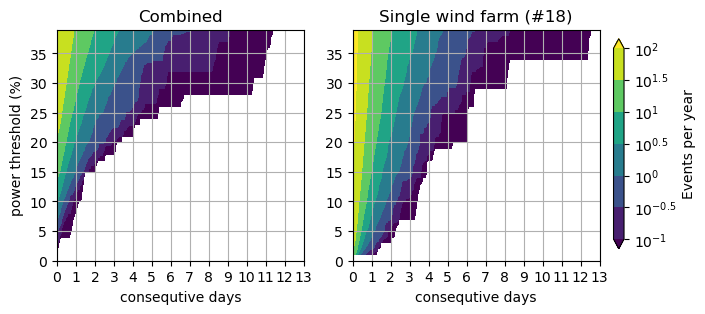

In [225]:
fig,axs=plt.subplots(ncols=2,figsize=(7,3))

df_dunkel_log10 = np.log10(df_dunkel)
levels2 = np.arange(-1,2.5,0.5)
xi,yi = np.meshgrid(df_dunkel_log10.index,df_dunkel_log10.columns)
axs[0].contourf(xi/24,yi,df_dunkel_log10.T.values, alpha=1,levels=levels2,extend="both")#, cmap="Blues");
#fmtr = matplotlib.ticker.FuncFormatter(lambda pos,x: "$10^{%g}$" % pos)
#cbar=plt.colorbar(label="Events per year",format=fmtr)#ticks=[-1,0,1,2,3,4,5],tick_labels=[0.1,1,10,100,1000])
axs[0].set_xlabel("consequtive days");
axs[0].set_ylabel("power threshold (%)")
#ax.xaxis.set_major_formatter(fmtr)
axs[0].set_xlim(0,13)
axs[0].set_xticks(range(14))
axs[0].grid()
#plt.gcf().set_size_inches(4, 3)
axs[0].set_title("Combined")
#plt.savefig("noreg_30GW/fig_dunkelflaute.png",bbox_inches='tight',dpi=150)
#plt.savefig("noreg_30GW/fig_dunkelflaute.pdf",bbox_inches='tight',dpi=150)

#plt.figure()
df_dunkel_log10 = np.log10(df_dunkel_0)
levels2 = np.arange(-1,2.5,0.5)
xi,yi = np.meshgrid(df_dunkel_log10.index,df_dunkel_log10.columns)
h= axs[1].contourf(xi/24,yi,df_dunkel_log10.T.values, alpha=1,levels=levels2,extend="both")#, cmap="Blues");
fmtr = matplotlib.ticker.FuncFormatter(lambda pos,x: "$10^{%g}$" % pos)
#cbar=plt.colorbar(label="Events per year",format=fmtr)#ticks=[-1,0,1,2,3,4,5],tick_labels=[0.1,1,10,100,1000])
plt.xlabel("consequtive days");
#plt.ylabel("power threshold (%)")
#ax.xaxis.set_major_formatter(fmtr)
plt.grid()
#plt.gcf().set_size_inches(4, 3)
plt.xlim(0,13)
plt.xticks(range(14))
plt.title(f"Single wind farm (#{wf_sn2})")

im = h
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax, label="Events per year",format=fmtr)#ticks=[-1,0,1,2,3,4,5],tick_labels=[0.1,1,10,100,1000])

plt.savefig("plots1/fig_windpower_dunkelflaute2.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_dunkelflaute2.pdf",bbox_inches='tight',dpi=plot_dpi)

## Wind power ramping

In [45]:
df_shifts={}#pd.DataFrame()
df_shifts_combined={}
for N_shift in range(26):
    df_shifts[N_shift] = (df_all_el-df_all_el.shift(N_shift))
    df_shifts_combined[N_shift] = (df_el_30GW-df_el_30GW.shift(N_shift))
df_shifts = pd.concat(df_shifts)
df_shifts_combined = pd.concat(df_shifts_combined)

In [59]:
def ramp_level(df_timeseries,df_shift):
    df = pd.DataFrame()
    N_years=len(df_timeseries.index.year.unique())
    abschange = df_shift.unstack(0).abs()
    
    for change in range(100):
        df[change] = (abschange > change/100).sum()/N_years

    df[df==0]=np.nan
    return df

df_ramplevel = ramp_level(df_el_30GW,df_shifts_combined)
df_ramplevel_0 = ramp_level(df_all_el[wf_sn2],df_shifts[wf_sn2])
#df_ramplevel,ramp_rate = ramp_level(df_el_30GW,df_shifts_combined)
#df_ramplevel_0,lramp_rate_0 = dunkel(df_all_el[wf_sn2])

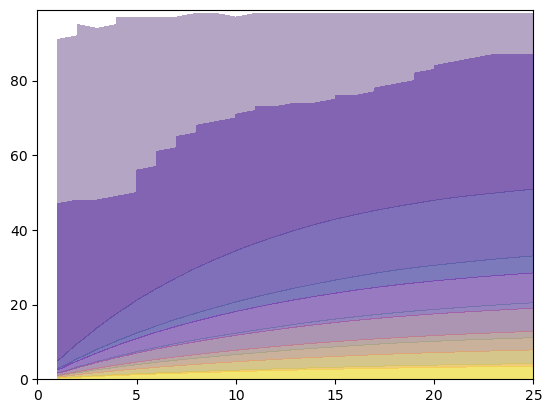

In [60]:
plt.contourf(df_ramplevel_0.T,alpha=0.4)
plt.contourf(df_ramplevel.T,cmap="plasma",alpha=0.4)

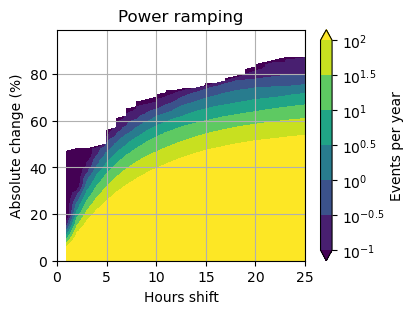

In [61]:
fig,ax=plt.subplots(ncols=1,figsize=(4,3))
df_ramplevel_log10 = np.log10(df_ramplevel)

#levels2 = np.arange(0,100,10)
#levels2 = [0,1,5,10,50,100]
#xi,yi = np.meshgrid(df_ramplevel.index,df_ramplevel.columns)
#im = ax.contourf(xi,yi,df_ramplevel.T.values, alpha=1, levels=levels2,cmap="viridis");
#fmtr = "%g"
levels2 = np.arange(-1,2.01,0.5)
xi,yi = np.meshgrid(df_ramplevel_log10.index,df_ramplevel_log10.columns)
im = ax.contourf(xi,yi,df_ramplevel_log10.T.values, alpha=1,levels=levels2,extend="both", cmap="viridis");
fmtr = matplotlib.ticker.FuncFormatter(lambda pos,x: "$10^{%g}$" % pos)
ax.set_xlabel("Hours shift");
ax.set_ylabel("Absolute change (%)")
ax.grid()
ax.set_title("Power ramping")

cbar=fig.colorbar(im, label="Events per year",format=fmtr)
plt.savefig("plots1/fig_windpower_ramplevels.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_ramplevels.pdf",bbox_inches='tight',dpi=plot_dpi)

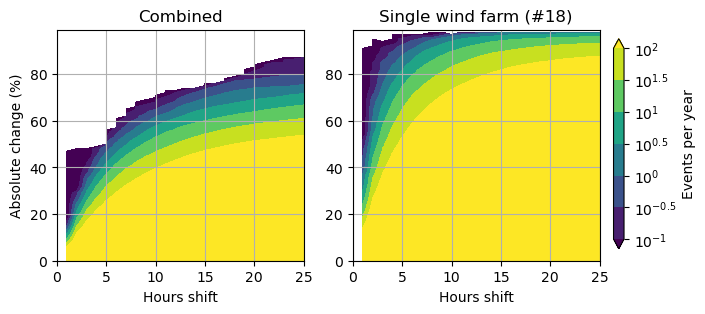

In [64]:
fig,axs=plt.subplots(ncols=2,figsize=(7,3))

levels2 = np.arange(-1,2.5,0.5)
fmtr = matplotlib.ticker.FuncFormatter(lambda pos,x: "$10^{%g}$" % pos)

df_ramplevel_log10 = np.log10(df_ramplevel)
xi,yi = np.meshgrid(df_ramplevel_log10.index,df_ramplevel_log10.columns)
axs[0].contourf(xi,yi,df_ramplevel_log10.T.values, alpha=1,levels=levels2,extend="both", cmap="viridis");
axs[0].set_xlabel("Hours shift");
axs[0].set_ylabel("Absolute change (%)")
axs[0].grid()
axs[0].set_title("Combined")

df_ramplevel_0_log10 = np.log10(df_ramplevel_0)
xi,yi = np.meshgrid(df_ramplevel_0_log10.index,df_ramplevel_0_log10.columns)
im=axs[1].contourf(xi,yi,df_ramplevel_0_log10.T.values, alpha=1,levels=levels2,extend="both", cmap="viridis");
axs[1].set_xlabel("Hours shift");
#axs[1].set_ylabel("Absolute change (%)")
axs[1].grid()
axs[1].set_title("Combined")
axs[1].set_title(f"Single wind farm (#{wf_sn2})")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax, label="Events per year",format=fmtr)#ticks=[-1,0,1,2,3,4,5],tick_labels=[0.1,1,10,100,1000])

plt.savefig("plots1/fig_windpower_ramplevels2.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_ramplevels2.pdf",bbox_inches='tight',dpi=plot_dpi)

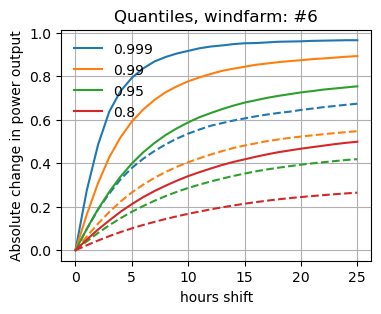

In [142]:
windfarm=wf_trondelag
df_shift=df_shifts[windfarm].unstack(0)
ax=None
for q in [0.999, 0.99, 0.95, 0.8]:
    ax=(df_shift.abs()).quantile(q=q).plot(ax=ax,label=q,xlabel="hours shift",grid=True)
    col=plt.gca().lines[-1].get_color()
    ax=(df_shifts_combined.unstack(0).abs()).quantile(q=q).plot(ax=ax,label='_nolegend_',color=col,linestyle="--",
                                                                xlabel="hours shift",ylabel="Absolute change in power output",grid=True)
plt.legend(frameon=False)
plt.title(f"Quantiles, windfarm: #{windfarm}");
plt.gcf().set_size_inches(4, 3)
plt.savefig("plots1/fig_windpower_ramps_single_windfarm.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_ramps_single_windfarm.pdf",bbox_inches='tight',dpi=plot_dpi)

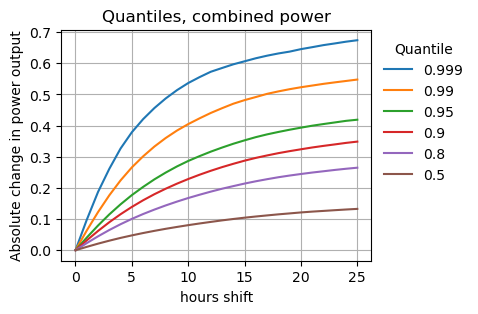

In [122]:
ax=None
for q in [0.999, 0.99, 0.95, 0.9, 0.8, 0.5]:
    ax=(df_shifts_combined.unstack(0).abs()).quantile(q=q).plot(ax=ax,label=q,xlabel="hours shift",ylabel="Absolute change in power output",grid=True)
plt.legend(title="Quantile",frameon=False,loc="upper left",bbox_to_anchor=(1,1),)
plt.title(f"Quantiles, combined power");
plt.gcf().set_size_inches(4, 3)
plt.savefig("plots1/fig_windpower_ramps_combined_quantils.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_ramps_combined_quantils.pdf",bbox_inches='tight',dpi=plot_dpi)

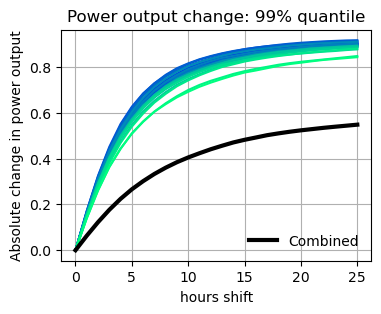

In [124]:
quantiles=df_shifts.unstack(0).abs().quantile(0.99)
quantiles_combined=df_shifts_combined.unstack(0).abs().quantile(0.99)

ax=quantiles.unstack(0).plot(cmap="winter")
#.legend(loc="lower left",bbox_to_anchor=(1,-0.05),frameon=False,title="windfarm");
quantiles_combined.plot(label="COMBINED",color="black",linewidth=3,ax=ax)
#.legend(loc="lower left",bbox_to_anchor=(1,-0.05),frameon=False,title="windfarm");
h,l = ax.get_legend_handles_labels()
plt.title("Power output change: 99% quantile")
plt.xlabel("hours shift")
plt.ylabel("Absolute change in power output")
plt.grid()
plt.legend([h[-1]],["Combined"],frameon=False,loc="lower right")#legend(loc="lower left",bbox_to_anchor=(1,-0.05),frameon=False,title="windfarm");
plt.gcf().set_size_inches(4, 3)
plt.savefig("plots1/fig_windpower_ramps_combined.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_ramps_combined.pdf",bbox_inches='tight',dpi=plot_dpi)

## Consumption Norway
* https://www.statnett.no/for-aktorer-i-kraftbransjen/tall-og-data-fra-kraftsystemet/last-ned-grunndata/
* MWh per hour

In [286]:
# test
demand = pd.read_html(f"../2022-06 30GW i Noreg/noreg_30GW/ProductionConsumption-{2020}.xls",header=0,index_col="Time(Local)",parse_dates=False)[0]
demand["time"] = pd.to_datetime(demand.index, errors='coerce',utc=True,format='%d.%m.%Y %H:%M:%S %z')

In [125]:
power_demand_year = []
for year in range(2015,2023):
    demand = pd.read_html(f"../2022-06 30GW i Noreg/noreg_30GW/ProductionConsumption-{year}.xls",header=0,index_col="Time(Local)",parse_dates=False)[0]
    demand["time"] = pd.to_datetime(demand.index, errors='coerce',utc=True,format='%d.%m.%Y %H:%M:%S %z')
    demand.set_index("time",inplace=True)
    power_demand_year.append(demand)
power_demand = pd.concat(power_demand_year)
power_demand=power_demand[power_demand.index.year>=2015]

demand2020=power_demand[power_demand.index.year==2020]

In [126]:
(power_demand.groupby(power_demand.index.year).sum()/1e6)


,Production,Consumption
time,,
2015,143.392781,128.617573
2016,148.807557,132.331560
2017,148.196324,132.885701
2018,145.666062,135.435604
2019,133.392314,133.471909
2020,153.336285,132.856085
2021,156.451158,138.914862
2022,144.094902,131.554480


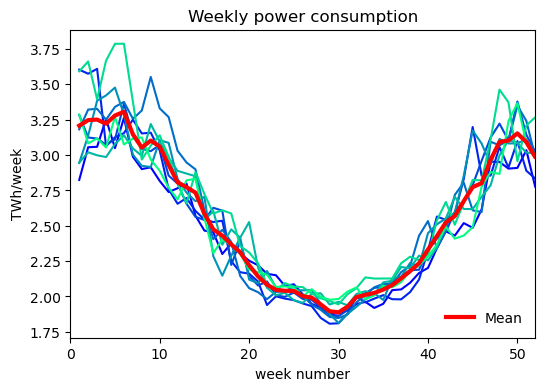

In [249]:
weekly_power = ((power_demand["Consumption"]/1e6).groupby([power_demand.index.year,power_demand.index.isocalendar().week]).mean()*7*24).unstack("time")
weekly_power.plot(figsize=(10,6),
   cmap="winter",xlim=(0,52),title="Weekly power consumption",xlabel="Week number",legend=False)
weekly_power.mean(axis=1).plot(color="red",linewidth=3,ax=plt.gca(),label="mean")
h,l = plt.gca().get_legend_handles_labels()
plt.legend([h[-1]],["Mean"],frameon=False,loc="lower right");
plt.ylabel("TWh/week")
plt.xlabel("week number")
plt.gcf().set_size_inches(6, 4)
#plt.savefig("plots1/fig_consumption_weekly.png",bbox_inches='tight',dpi=plot_dpi)
#plt.savefig("plots1/fig_consumption_weekly.pdf",bbox_inches='tight',dpi=plot_dpi)

In [132]:
(weekly_power.mean(axis=1).min()/weekly_power.mean(axis=1).max(),
(df_el_30GW).mean()*30*365*24/1000
)

(0.6250552739268862, 147.1954569900986)

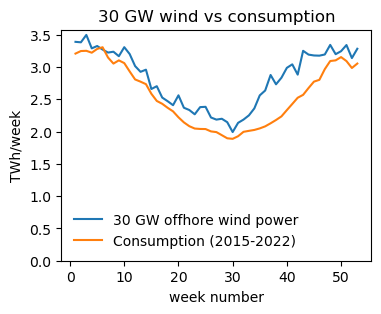

In [250]:
seasonal_combined_mean2=df_el_30GW.groupby(df_el_30GW.index.isocalendar().week).mean()*30/1000*24*7
ax=seasonal_combined_mean2.plot(label="30 GW offhore wind power")
weekly_power.mean(axis=1).plot(label="Consumption (2015-2022)",ax=ax)
net_load = seasonal_combined_mean2-weekly_power.mean(axis=1)
#net_load.plot(label="net load",ax=ax)
plt.legend(frameon=False)#,loc="upper left",bbox_to_anchor=(1,1))
plt.ylabel("TWh/week")
plt.xlabel("week number")
plt.title("30 GW wind vs consumption")
#plt.grid()
plt.gcf().set_size_inches(4, 3)
plt.ylim(ymin=0)
plt.savefig("plots1/fig_netload_weekly.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_netload_weekly.pdf",bbox_inches='tight',dpi=plot_dpi)

Text(0, 0.5, 'Power output (TWh/day)')

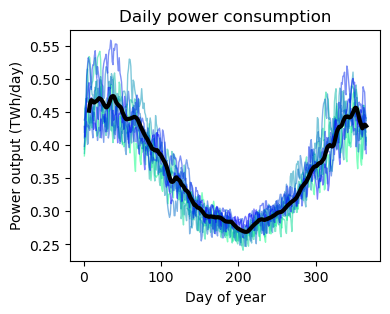

In [251]:
dailypower=(power_demand["Consumption"]/1e6).groupby([power_demand.index.year,power_demand.index.day_of_year]).sum().unstack(0)
dailypower = dailypower[dailypower.index<366]
dailypower.plot(figsize=(4,3),
   cmap="winter_r", linewidth=1,alpha=0.5,
   #color="gray", linewidth=1,
   title="Daily power consumption",xlabel="Day of year",legend=False)
dailypower.mean(axis=1).rolling(7,).mean().plot(color="black",linewidth=3,ax=plt.gca())
plt.xlabel("Day of year")
plt.ylabel("Power output (TWh/day)")

In [259]:
#weekly_power

In [278]:
df = (power_demand["Consumption"]/power_demand["Consumption"].max())

demand_weekly_mean=df.groupby([df.index.isocalendar().week,df.index.isocalendar().year]).mean()
demand_weekly_std=df.groupby([df.index.isocalendar().week,df.index.isocalendar().year]).std()
demand_combined_mean = demand_weekly_mean.unstack(1).mean(axis=1)
demand_combined_std = demand_weekly_mean.unstack(1).std(axis=1)
#demand_combined_min = demand_weekly_mean.unstack(1).min(axis=1)
#demand_combined_max = demand_weekly_mean.unstack(1).max(axis=1)

# Seasonal variation, including standard deviation (variations within week as well as variations from year to year)
#seasonal_combined_mean2=df_el_30GW.groupby(df_el_30GW.index.isocalendar().week).mean() # this is the same as seasonal_combined_mean
demand_combined_std2=df.groupby(df.index.isocalendar().week).std()
demand_combined_min = df.groupby(df.index.isocalendar().week).min()
demand_combined_max = df.groupby(df.index.isocalendar().week).max()

WEEKLY mean power demand. Mean and standard deviation (from year to year)


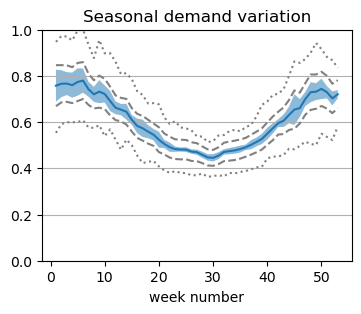

In [280]:
# Seasonal variation, including standard deviation for year-to-year variations in weekly mean values
ax=plt.plot(demand_combined_mean.index,demand_combined_mean,label="mean")
plt.fill_between(x=list(weekly_power.index),
    y1=demand_combined_mean-demand_combined_std,
    y2=demand_combined_mean+demand_combined_std,alpha=0.5,label="std year-year")
plt.plot(demand_combined_mean.index,demand_combined_mean-demand_combined_std2,
    linestyle="--",color="gray",label="std in week")
plt.plot(demand_combined_mean.index,demand_combined_mean+demand_combined_std2,
    linestyle="--",color="gray")
plt.plot(demand_combined_mean.index,demand_combined_min,
    linestyle=":",color="gray",label="max/min in week")
plt.plot(demand_combined_mean.index,demand_combined_max,
    linestyle=":",color="gray")

plt.xlabel("week number");
plt.title("Seasonal demand variation")
plt.ylim(0,1)
plt.grid(axis="y")
plt.gcf().set_size_inches(4, 3)
plt.savefig("plots1/fig_demand_seasonalvariation.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_demand_seasonalvariation.pdf",bbox_inches='tight',dpi=plot_dpi)
print("WEEKLY mean power demand. Mean and standard deviation (from year to year)")

In [252]:
df_shifts_demand={}
dem = power_demand["Consumption"]
#dem = (dem-dem.min())/(dem.max()-dem.min()) # normalise so demand has value 0-1
dem = (dem-dem.min())/(dem.max()) # normalise so demand has max value 1 (and min value >0)
for N_shift in range(26):
    df_shifts_demand[N_shift] = (dem-dem.shift(N_shift))
df_shifts_demand = pd.concat(df_shifts_demand)

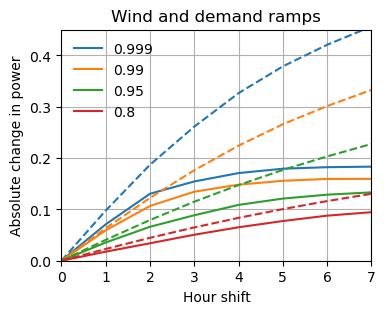

In [253]:

ax=None
for q in [0.999, 0.99, 0.95, 0.8]:
    quantiles_demand=df_shifts_demand.unstack(0).abs().quantile(q)
    quantiles_demand.plot(label=q)
    col=plt.gca().lines[-1].get_color()
    (df_shifts_combined.unstack(0).abs()).quantile(q=q).plot(ax=ax,label='_nolegend_',color=col,linestyle="--")
plt.legend(frameon=False)
plt.ylim([0,0.45])
plt.xlim([0,7])
plt.grid()
plt.title(f"Wind and demand ramps")
plt.xlabel("Hour shift")
plt.ylabel("Absolute change in power")
plt.gcf().set_size_inches(4, 3)
plt.savefig("plots1/fig_windpower_ramps_demand.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_windpower_ramps_demand.pdf",bbox_inches='tight',dpi=plot_dpi)

## Compare these time-series with actual production from existing wind farms


* Smøla: 
  * 2 MW x 20 + 2.3 MW x 48 = 150 MW, 
  * tower height: 70 m
  * turbine: Siemens SWT-2.3-CS 2,3 (phase 2)
  * diameter: 76,0/82,4 meter (phase 1/2)

In [766]:
2*20+2.3*48

150.39999999999998

In [151]:
# time index in UTC+1
actual_wind_power = pd.read_excel("C:/Users/hsven/OneDrive - SINTEF/DATA/vind_nve/vindproduksjon_2002-2020_faktisk_produksjonutc-1.xlsx",
                                  skiprows=[1,2],index_col=0)
# change timezone from UTC+1 to UTC (shift index -1, so hour=02 becomes hour=01)
actual_wind_power = actual_wind_power.shift(-1)

In [152]:
# Previously computed using ninja data:
model_smola = pd.read_excel("wind_power_ninja_smola.xlsx",index_col=0)

In [153]:
#dfplot = pd.DataFrame()
#dfplot["model"] = model_smola[["electricity"]]
#dfplot["actual"] = actual_wind_power["Smøla"]/150 # 150 MW capacity in the selected period
dfplot = pd.concat({"actual":actual_wind_power["Smøla"]/150,"model":model_smola["electricity"]},axis=1)
dfplot = dfplot.dropna(axis=0)

In [154]:
# Actual power output is much less than model gives:
dfplot.mean()

actual    0.252165
model     0.314940
dtype: float64

In [92]:
# Correlation coefficient between model and actual (0.8378)
dfplot.corr()

,actual,model
actual,1.000000,0.844326
model,0.844326,1.000000


In [1]:
# px.line(dfplot)


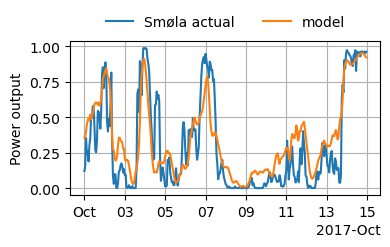

In [161]:
# October 2017
dfplot2=dfplot[(dfplot.index>="2017-10-01") & (dfplot.index<"2017-10-15")]
fig=plt.figure(figsize=(4,2))
ax=plt.gca()
ax.plot(dfplot2.index,dfplot2[["actual","model"]],label=["Smøla actual","model"])
plt.ylabel("Power output")
#plt.xlabel("Day")
#plt.title("Smøla")
plt.grid()
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.legend(frameon=False,bbox_to_anchor=(0.5,1),loc="lower center",ncol=2)
plt.savefig("plots1/fig_smola.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_smola.pdf",bbox_inches='tight',dpi=plot_dpi)

Model overestimates high wind power values


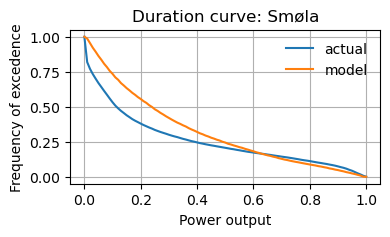

In [162]:
durcurve=duration_curve(dfplot)
durcurve.plot(title="Duration curve: Smøla",xlabel="Power output",ylabel="Frequency of excedence")
plt.grid()
plt.gcf().set_size_inches(4, 2)
plt.legend(frameon=False)
plt.savefig("plots1/fig_smola_durationcurves.png",bbox_inches='tight',dpi=plot_dpi)
plt.savefig("plots1/fig_smola_durationcurves.pdf",bbox_inches='tight',dpi=plot_dpi)
print("Model overestimates high wind power values")

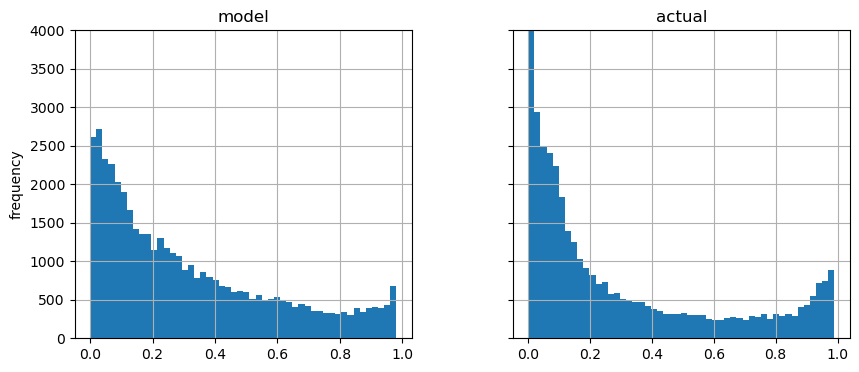

In [359]:
axs=dfplot.hist(bins=50,figsize=(10,4),sharey=True);
plt.ylim(0,4000)
axs[0][0].set_ylabel("frequency");

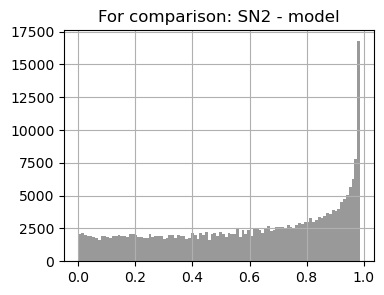

In [378]:
# Power histogram for Smøla is very different from offshore locations, so possibly it is not so suited to 
# benchmark method for offshore locations
df_all_el[wf_sn2].hist(bins=100,alpha=0.4,color="black",label="Single wind farm")
plt.title("For comparison: SN2 - model");
plt.gcf().set_size_inches(4, 3)

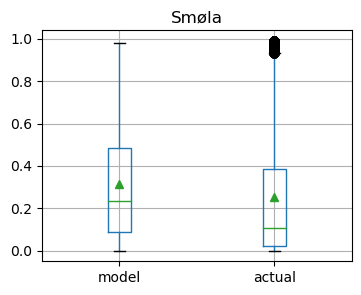

In [375]:
dfplot.boxplot(figsize=(4,3),showmeans=True)
plt.title("Smøla");

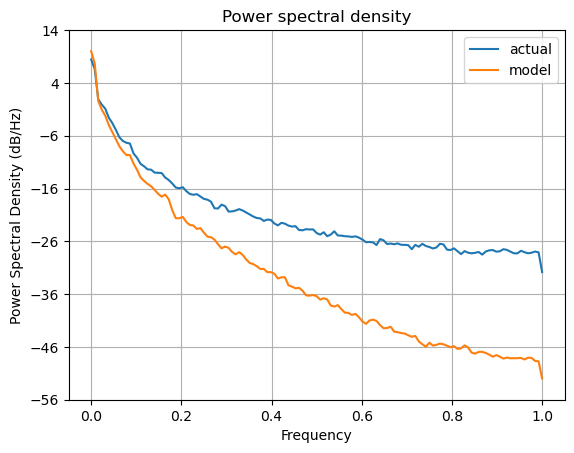

In [373]:
plt.figure()
plt.title("Power spectral density")
ax=plt.gca()
ax.psd(dfplot["actual"],label="actual")
ax.psd(dfplot["model"],label="model")
plt.legend()

In [371]:
#px.line(dfplot.resample("1w").mean())

### Wind power dataset from DTU

Download dataset from here: https://doi.org/10.11583/DTU.19690606.v1  
19691002.zip


In [18]:
from zipfile import ZipFile

zip_file = ZipFile("19690606.zip")
dtu_data = pd.read_csv(zip_file.open("SP316.csv"),index_col="Time",parse_dates=["Time"])

In [21]:
dtu_data.dropna(axis=1).columns

Index(['AL00_OFF', 'BA00_OFF', 'BE00_OFF', 'BE01_OFF', 'BG00_OFF', 'BG01_OFF',
       'CY00_OFF', 'DBOT_OFF', 'DBUK_OFF', 'DE00_OFF',
       ...
       'UK03_OFF', 'UK041_OFF', 'UK042_OFF', 'UK043_OFF', 'UK04_OFF',
       'UK051_OFF', 'UK052_OFF', 'UK053_OFF', 'UK05_OFF', 'UKNI_OFF'],
      dtype='object', length=119)

NON1
NOM1
NOS3
NOS21
NOS22


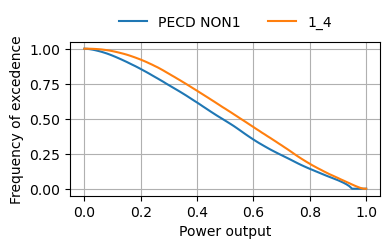

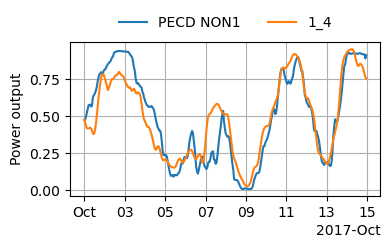

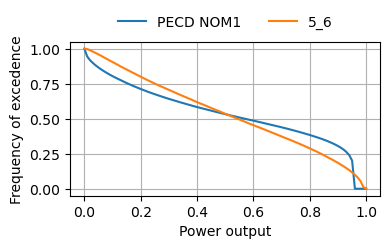

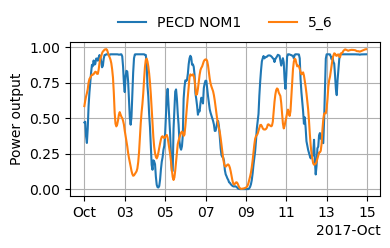

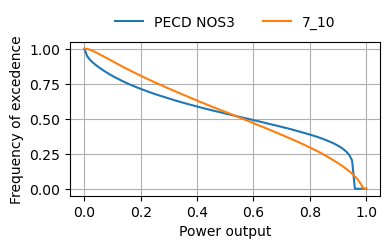

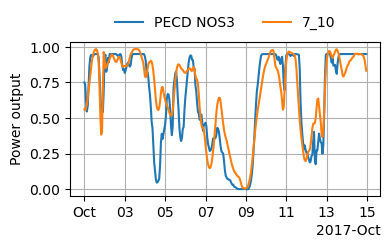

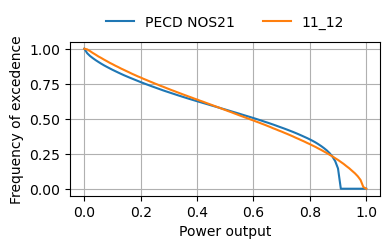

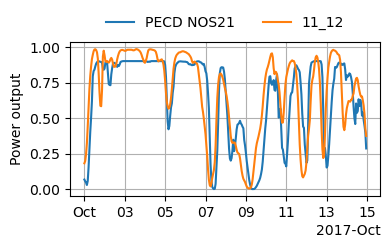

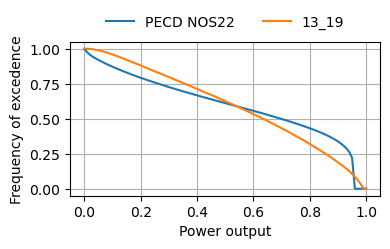

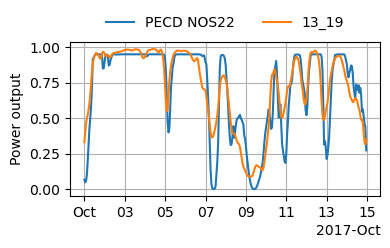

In [132]:
ar={"NON1":[1,2,3,4],
    "NOM1":[5,6],
    "NOS3":[7,8,9,10],
    "NOS21":[11,12],
    "NOS22":[13,14,15,16,17,18,19]
    }
for k,v in ar.items():
    print(k)

    dfplot = pd.concat({f"PECD {k}":dtu_data[f"{k}_OFF"],f"{v[0]}_{v[-1]}":df_all_el[v].mean(axis=1)},axis=1)
    dfplot = dfplot.dropna(axis=0)

    durcurve=duration_curve(dfplot)
    durcurve.plot(xlabel="Power output",ylabel="Frequency of excedence")
    plt.grid()
    plt.gcf().set_size_inches(4, 2)
    plt.legend(frameon=False,bbox_to_anchor=(0.5,1.0),loc="lower center",ncol=2)
    plt.savefig(f"plots1/fig_dtu_{k}_durationcurves.png",bbox_inches='tight',dpi=plot_dpi)
    plt.savefig(f"plots1/fig_dtu_{k}_durationcurves.pdf",bbox_inches='tight',dpi=plot_dpi)

    dfplot2=dfplot[(dfplot.index>="2017-10-01") & (dfplot.index<"2017-10-15")]
    fig=plt.figure(figsize=(4,2))
    ax=plt.gca()
    ax.plot(dfplot2.index,dfplot2,label=dfplot2.columns)
    plt.ylabel("Power output")
    #plt.xlabel("Day")
    #plt.title(f"Wind farm #{wf_trondelag} vs NOM1")
    plt.grid()
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.legend(frameon=False,bbox_to_anchor=(0.5,1.0),loc="lower center",ncol=2)
    plt.savefig(f"plots1/fig_dtu_{k}.png",bbox_inches='tight',dpi=plot_dpi)
    plt.savefig(f"plots1/fig_dtu_{k}.pdf",bbox_inches='tight',dpi=plot_dpi)

    dfplot.corr()

In [128]:
dfplot.corr()

,PECD NOM1,5_6
PECD NOM1,1.00000,0.62328
5_6,0.62328,1.00000


In [137]:
dtu_data[["NON1_OFF","NOM1_OFF","NOS3_OFF","NOS21_OFF","NOS22_OFF"]].corr()

,NON1_OFF,NOM1_OFF,NOS3_OFF,NOS21_OFF,NOS22_OFF
NON1_OFF,1.000000,0.265560,0.239252,0.111803,0.111032
NOM1_OFF,0.265560,1.000000,0.937536,0.181771,0.182295
NOS3_OFF,0.239252,0.937536,1.000000,0.222552,0.221992
NOS21_OFF,0.111803,0.181771,0.222552,1.000000,0.951623
NOS22_OFF,0.111032,0.182295,0.221992,0.951623,1.000000


In [136]:
our_data = pd.DataFrame()
for k,v in ar.items():
    our_data[k]=df_all_el[v].mean(axis=1)
our_data.corr()

,NON1,NOM1,NOS3,NOS21,NOS22
NON1,1.000000,0.390810,0.196944,0.130833,0.103619
NOM1,0.390810,1.000000,0.460584,0.280162,0.178645
NOS3,0.196944,0.460584,1.000000,0.790134,0.513731
NOS21,0.130833,0.280162,0.790134,1.000000,0.755883
NOS22,0.103619,0.178645,0.513731,0.755883,1.000000


In [150]:
#dtu_data[dtu_data.columns[dtu_data.columns.str.startswith("NO")]].hist(bins=50)
#df_all_el[[1,6,10,18]].hist(bins=50)
#our_data.hist(bins=50)

<AxesSubplot: ylabel='Frequency'>

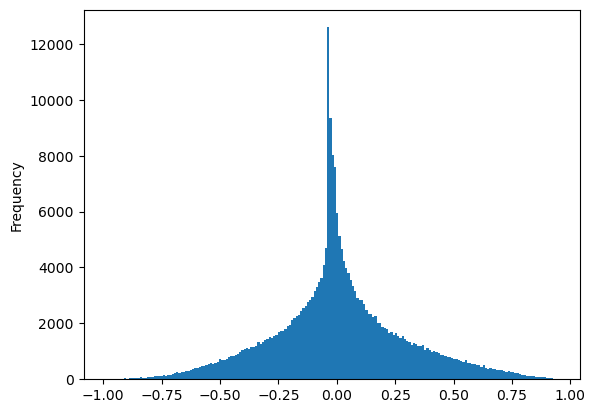

In [60]:
(dfplot["PECD NOM1"]-dfplot[6]).plot.hist(bins=200)
#dfplot.plot.scatter(x="PECD NOM1",y=6,alpha=0.01,marker=".")